In [692]:
import twitter
import spacy
import nltk
import gzip
import re
import json
import itertools
import functools
import spacy_readability
import string
import collections
import datetime
import importlib
import pandas as pd
import numpy as np
import scipy
import pickle

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook 

In [570]:
import sklearn
from sklearn import tree as skl_tree
from sklearn import metrics as skl_metrics
from sklearn import model_selection as skl_model_selection
from sklearn import linear_model as skl_linear
from sklearn import naive_bayes as skl_naive_bayes
from sklearn import preprocessing as skl_preprocess
from sklearn import feature_extraction as skl_ftex

In [279]:
#  List of twitter personalities to import
TWITTER_HANDLES = [    
    'jimmyfallon',
    'trevornoah',
    'billmaher',
    'stephenathome',
    'jimmyfallon',
    'britneyspears',
    'selenagomez',
    'kimkardashian',
    'jtimberlake',
    'realdonaldtrump',
    'arianagrande',
    'theellenshow',
    'ladygaga',
    'taylorswift13',
    'rihanna',
    'justinbieber',
    'katyperry',
    'billgates',
    'mileycyrus',
    'jlo',
    'kingjames',
    'brunomars',
    'chrissyteigen',
    'oprah',
    'drake',
    'pink',
    'liltunechi',
    'kevinhart4real',
    'elonmusk',
    'kyliejenner',
    'conanobrien',
    'mariahcarey',
    'davidguetta',
    'jk_rowling'
]

In [275]:
#  Location to persist JSON data (so we don't need to re-load from API)
SAVE_LOCATION = '/Users/liangjh/Workspace/tweemio-api/data/timelines'

In [276]:
#  Number of tweets to combine
CONDENSE_FACTOR = 2

## Initialize NLP (Spacy)

In [292]:
from spacy.lang.en.stop_words import STOP_WORDS

In [293]:
#  Initialize NLP parser / document processor
#  Load small english dictionary, + readability metric pipeline
nlp = spacy.load("en_core_web_sm")

#  Limit to pipeline we'll definitely need
nlp.disable_pipes(*['tagger', 'parser', 'ner']) # all this stuff not needed
nlp.add_pipe(nlp.create_pipe('sentencizer'))  # we only need sentence parsing
nlp.add_pipe(spacy_readability.Readability(), last=True)
#  TODO: may remove NER from pipeline, if not used

## Twitter API Initialization

In [462]:
twitter_credentials = {
    'consumer_key':        'wbz78wFd0ywcShiTvqgDUV2ry',
    'consumer_secret':     '2qj0P3fygqa0n2LqU6M8LV485OWIAvXWEQOEVLWFNUBdKDcgjz',
    'access_token_key':    '80578720-t7bH4zwD6Q6sUQEFeCb8211wH04Y9ul0EWECo2ofU',
    'access_token_secret': 'PSsX8R4agpxAII9XCYHqE74KObPRWfl9tdG4Xd07olOn6'
}

In [463]:
twapi = twitter.Api(consumer_key=twitter_credentials['consumer_key'],
                    consumer_secret=twitter_credentials['consumer_secret'],
                    access_token_key=twitter_credentials['access_token_key'],
                    access_token_secret=twitter_credentials['access_token_secret'],
                    tweet_mode='extended')

## Download Timelines (Twitter)

In [472]:
def timeline_download(screen_name: str, twapi):
    '''
    Returns timeline for a given screen name
    twitter.Api is expected to be initialized
    '''
    print('Retrieving timeline for: {}'.format(screen_name))
    timeline = []
    max_id = None
    while True:        
        print('     max_id for iteration: {}'.format(max_id))
        tweets = twapi.GetUserTimeline(screen_name=screen_name, include_rts=False, count=200, max_id=max_id)
        timeline += tweets

        if len(tweets) < 1:
            break        
        next_max_id = min(tweets, key=lambda t: t.id).id
        if next_max_id == max_id:
            break
        max_id = next_max_id
    return timeline


In [ ]:
#  Download all, place into dict; 
#  Serialize to JSON, save w/ timestamp
timeline_map = {}
for screen_name in TWITTER_HANDLES:
    user_timeline = timeline_download(screen_name, twapi)
    timeline_map[screen_name] = user_timeline

In [ ]:
for screen_name, tline in timeline_map.items():
    print(f'writing {screen_name} to file...')
    tline_js = [tli._json for tli in tline]
    with open("{}/{}-{}.json".format(SAVE_LOCATION, screen_name, datetime.date.today().strftime('%Y%m%d')), "w") as outfile:
        json.dump(tline_js, outfile)

In [683]:
timeline_text = {screen_name: list(reversed([tli._json['full_text'] for tli in tline])) 
                 for screen_name, tline in timeline_map.items()}

## Extract Saved Timelines

In [ ]:
#  All timeline JSON saved to file system (as of last retrieval)
#  Load / parse for extraction
timeline_map = {}
for screen_name in TWITTER_HANDLES:
    print(f'Loading {screen_name}')
    fileloc = f'{SAVE_LOCATION}/{screen_name}-20191224.json'
    with open(fileloc, 'r') as infile:
        content = json.load(infile)
        timeline_map[screen_name] = content

In [286]:
timeline_text = {screen_name: list(reversed([tli['full_text'] for tli in tline])) 
                 for screen_name, tline in timeline_map.items()}

In [686]:
timeline_text = {screen_name:tl[-400:] for screen_name,tl in timeline_text.items()}

## Extract, Construct

In [687]:
#  Remove non-parseable patterns ** adjustable **
def timeline_text_construct(timeline_text: list, filter_regex: str='^(http)', condense_factor: int=1) -> list:
    '''
    Constructs timeline text based on filter regex as well as condense factor
    (i.e. number of tweets to compress together)
    '''
    timeline_text = [' '.join([('' if (re.search(filter_regex, word) != None) else word) for word in text.split()]) for text in timeline_text]
    timeline_text = [t for t in timeline_text if len(t.strip()) > 0]

    #  Group by condense factor (i.e. grouping multiple tweets into single tweet)
    timeline_text = [
        ' '.join(timeline_group) for timeline_group in 
        zip(*[timeline_text[n::condense_factor] for n in range(0, condense_factor)])
    ]
    
    return timeline_text

In [688]:
#  Combine all timelines into a single dataframe, for feature extraction
tl_dfs = []
for screen_name, tline in timeline_text.items():
    print(f'Processing {screen_name}...')

    #  Parse tweet list: full text, nomention and mention-only
    tline_text = timeline_text_construct(tline, '^(http)', CONDENSE_FACTOR)
    tline_text_nomention = [' '.join([('' if (re.match(r'^(@|#|http)', word) != None) else word) for word in text.split()]).strip() for text in tline_text]    
    tline_text_mention   = [' '.join([('' if (re.match(r'^(@|#)', word) == None) else word) for word in text.split()]).strip() for text in tline_text]
    
    tl_df = pd.DataFrame({'screenname': screen_name, 'text': tline_text, 'text_nomention': tline_text_nomention, 'text_mention': tline_text_mention})
    tl_dfs.append(tl_df)

feature_df = pd.concat(tl_dfs)

Processing jimmyfallon...
Processing trevornoah...
Processing billmaher...
Processing stephenathome...
Processing britneyspears...
Processing selenagomez...
Processing kimkardashian...
Processing jtimberlake...
Processing realdonaldtrump...
Processing arianagrande...
Processing theellenshow...
Processing ladygaga...
Processing taylorswift13...
Processing rihanna...
Processing justinbieber...
Processing katyperry...
Processing billgates...
Processing mileycyrus...
Processing jlo...
Processing kingjames...
Processing brunomars...
Processing chrissyteigen...
Processing oprah...
Processing drake...
Processing pink...
Processing liltunechi...
Processing kevinhart4real...
Processing elonmusk...
Processing kyliejenner...
Processing conanobrien...
Processing adele...
Processing mariahcarey...
Processing davidguetta...
Processing jk_rowling...


## Feature Extraction

In [294]:
#  Parse with spacy.io NLP parser
feature_df['nlpdoc'] = feature_df.apply(lambda r: nlp(r['text']), axis=1)

In [295]:
#  Word / sentence counts (foundations)
feature_df['words_per_sentence'] = feature_df.apply(lambda r: np.mean([len(s) for s in list(r['nlpdoc'].sents)]), axis=1)
feature_df['words_per_segment'] = feature_df.apply(lambda r: len(r['text'].split()), axis=1)
feature_df['sentences_per_segment'] = feature_df.apply(lambda r: len(list(r['nlpdoc'].sents)), axis=1)

In [296]:
#  Readability metrics / scores
feature_df['re_fkgl']  = feature_df.apply(lambda r: r['nlpdoc']._.flesch_kincaid_grade_level, axis=1)
feature_df['re_fkre']  = feature_df.apply(lambda r: r['nlpdoc']._.flesch_kincaid_reading_ease, axis=1)
feature_df['re_dc']    = feature_df.apply(lambda r: r['nlpdoc']._.dale_chall, axis=1)
feature_df['re_cl']    = feature_df.apply(lambda r: r['nlpdoc']._.coleman_liau_index, axis=1)
feature_df['re_autor'] = feature_df.apply(lambda r: r['nlpdoc']._.automated_readability_index, axis=1)

In [297]:
#  Matching word extensions
feature_df['extensions_segment'] = feature_df.apply(
    lambda r: len(re.findall(r'(\w)\1{2,}', r['text'])) / r['words_per_segment'], axis=1)
#  Average punctuations per sentence
feature_df['punc_per_sent'] = feature_df.apply(
    lambda r: len(re.findall(r'(\!|\?|\"|\'|\"|\,|\:|\;|\.)+', r['text'])) / r['sentences_per_segment'], axis=1)
#  Cap BOS: sentences w/ first word capitalized / number sentences (avg)
feature_df['bos_cap_per_sent'] = feature_df.apply(
    lambda r: len([str(s[0])[0].isupper() for s in r['nlpdoc'].sents]) / len(list(r['nlpdoc'].sents)), axis=1)
#  All caps: per segment
feature_df['allcaps_per_segment'] = feature_df.apply(
    lambda r: len([word for word in r['nlpdoc'] if str(word).isupper()]) / len(r['nlpdoc']), axis=1)
#  Alphanumeric: words per segment (tweet)
feature_df['alphanum_per_segment'] = feature_df.apply(
    lambda r: len([word for word in r['nlpdoc'] if re.match(r'([0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+)', str(word)) != None]) / r['words_per_segment'], axis=1)
#  Upper-case letters per tweet (normalized to number of characters)
feature_df['upcase_per_segment'] = feature_df.apply(
    lambda r: len([char for word in r['nlpdoc'] for char in str(word) if char.isupper()]) / r['words_per_segment'], axis=1)

In [298]:
#  Mentions / hashtags as ratio of total tokens in segment
feature_df['mention_ratio'] = feature_df.apply(lambda r: len([mention for mention in r['text_mention'] if mention.startswith('@')]) / r['words_per_segment'], axis=1)
feature_df['hashtag_ratio'] = feature_df.apply(lambda r: len([mention for mention in r['text_mention'] if mention.startswith('#')]) / r['words_per_segment'], axis=1)

In [299]:
# If quotations are used, then will contain at least 3 elements even if entire thing is a quote
feature_df['has_quotes'] = feature_df.apply(lambda r: len(r['text'].split('\"')) > 2, axis=1)

In [300]:
feature_df.describe()

,words_per_sentence,words_per_segment,sentences_per_segment,re_fkgl,re_fkre,re_dc,re_cl,re_autor,extensions_segment,punc_per_sent,bos_cap_per_sent,allcaps_per_segment,alphanum_per_segment,upcase_per_segment,mention_ratio,hashtag_ratio
count,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000,39044.0,39044.000000,39044.000000,39044.000000,39044.000000,39044.000000
mean,13.380761,26.934996,2.938300,5.974905,72.132607,10.206526,7.639619,5.941920,0.006634,1.416403,1.0,0.046589,0.006112,0.526119,0.057363,0.047323
std,8.003326,16.134617,1.597166,5.116264,32.384771,3.001461,7.098094,6.324772,0.037683,1.022036,0.0,0.069018,0.029514,0.561689,0.090074,0.101476
min,1.500000,2.000000,1.000000,-11.280000,-3075.498571,0.049600,-39.520000,-16.220000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.333333,15.000000,2.000000,3.216134,60.014257,8.153486,4.208710,2.407895,0.000000,1.000000,1.0,0.000000,0.000000,0.230769,0.000000,0.000000
50%,11.500000,25.000000,3.000000,5.479613,75.142500,9.623803,7.249000,5.311935,0.000000,1.250000,1.0,0.030303,0.000000,0.380952,0.028571,0.000000
75%,16.000000,35.000000,4.000000,8.113750,88.103026,11.663767,10.546857,8.752083,0.000000,1.833333,1.0,0.062500,0.000000,0.631579,0.076923,0.058824
max,203.000000,120.000000,18.000000,443.968571,184.840000,29.495300,443.651429,353.487143,1.666667,24.000000,1.0,1.000000,1.000000,23.833333,1.000000,1.000000


In [546]:
feature_df.groupby('screenname').describe().to_csv('/Users/liangjh/Desktop/tweemio-summary.csv')

## Word Frequency Extraction

Frequency of words, across the entire corpus

In [510]:
feature_df.screenname.unique()

array(['jimmyfallon', 'trevornoah', 'billmaher', 'stephenathome',
       'britneyspears', 'selenagomez', 'kimkardashian', 'jtimberlake',
       'realdonaldtrump', 'arianagrande', 'theellenshow', 'ladygaga',
       'taylorswift13', 'rihanna', 'justinbieber', 'katyperry',
       'billgates', 'mileycyrus', 'jlo', 'kingjames', 'brunomars',
       'chrissyteigen', 'oprah', 'drake', 'pink', 'liltunechi',
       'kevinhart4real', 'elonmusk', 'kyliejenner', 'conanobrien',
       'adele', 'mariahcarey', 'davidguetta', 'jk_rowling'], dtype=object)

In [ ]:
screen_name = 'realdonaldtrump'
corpus = feature_df.loc[feature_df.screenname == screen_name, ['text_nomention']]
corpus_joined = ' '.join(list(corpus.text_nomention))

# Eliminate stop words and compound words (w/ contractions)
corpus_word_counts = collections.Counter(
            [word.lower() for word in corpus_joined.split() 
                if (word.lower() not in STOP_WORDS and re.search(r"('|-|&|:|!|;)+", word) == None)]
        ).items()

#  Get "most frequent" words for this user
corpus_word_counts_sorted = sorted(corpus_word_counts, key=lambda x: x[1], reverse=True)

## Persist, Reload

In [622]:
# feature_df[feature_df.columns.difference(['nlpdoc'])].to_pickle('/Users/liangjh/Desktop/feature_df.pik')
# feature_df = pd.read_pickle('/Users/liangjh/Desktop/feature_df.pik')
# feature_df[feature_df.columns.difference(['has_quotes', 'text' ,'text_mention', 'screenname'])].corr().to_csv('/Users/liangjh/Desktop/tweemio-corrs.csv')

## EXPLORATION

In [215]:
# feature_df.loc[feature_df.screenname == 'katyperry', ['re_autor', 're_cl', 're_dc', 're_fkgl', 're_fkre']]

In [542]:
# list(feature_df.loc[feature_df.screenname == 'adele'].text)

In [182]:
feature_df.columns

Index(['allcaps_per_segment', 'alphanum_per_segment', 'bos_cap_per_sent',
       'extensions_segment', 'has_quotes', 'hashtag_ratio', 'mention_ratio',
       'punc_per_sent', 're_autor', 're_cl', 're_dc', 're_fkgl', 're_fkre',
       'screenname', 'sentences_per_segment', 'text', 'text_mention',
       'text_nomention', 'upcase_per_segment', 'words_per_segment',
       'words_per_sentence'],
      dtype='object')

(array([1.1600e+02, 3.1400e+02, 8.9100e+02, 3.3220e+03, 1.2455e+04,
        1.6994e+04, 4.1980e+03, 5.6100e+02, 3.7000e+01, 2.0000e+00]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <a list of 10 Patch objects>)

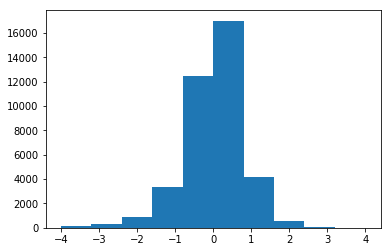

In [302]:
feat = [[val] for val in feature_df.re_fkre]
scaler = skl_preprocess.StandardScaler().fit(feat)
scaled = scaler.transform(feat)
plt.hist(scaled, range=(-4,4))

## MODELING

### Multinomial Logit: Using Extracted Variables

In [303]:
feature_cols = ['words_per_sentence', 'words_per_segment', 'sentences_per_segment',
                'extensions_segment', 'punc_per_sent', 'bos_cap_per_sent',
                'allcaps_per_segment', 'alphanum_per_segment', 'upcase_per_segment',
                'mention_ratio', 'hashtag_ratio', 'has_quotes',
                're_fkgl', 're_fkre', 're_dc', 're_cl', 're_autor']
# feature_cols = ['re_fkgl', 're_fkre', 're_dc', 're_cl', 're_autor']

In [543]:
# Binarize test
# feature_df['sn'] = feature_df.apply(lambda r: 'realdonaldtrump' if r['screenname'] == 'realdonaldtrump' else 'NOT_realdonaldtrump', axis=1)

In [544]:
x = feature_df.loc[:,  feature_cols].values
y = feature_df.screenname

In [545]:
#  Training / test set separation
x_train, x_test, y_train, y_test = skl_model_selection.train_test_split(x, y, random_state=0)

In [546]:
#  Scale all variables 
scaler  = skl_preprocess.StandardScaler()
scaler  = scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

In [202]:
# dtree_model = skl_tree.DecisionTreeClassifier().fit(x_train, y_train)
# dtree_predictions = dtree_model.predict(x_test)

In [549]:
logit_model = skl_linear.LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg').fit(x_train, y_train)
# logit_model = skl_linear.LogisticRegression(random_state=0).fit(x_train, y_train)
logit_predictions = logit_model.predict(x_test)
logit_predictions_prob = logit_model.predict_proba(x_test)

In [551]:
label_list = sorted(feature_df.sn.unique())
cm = skl_metrics.confusion_matrix(y_test, logit_predictions, labels=label_list)
cm_df = pd.DataFrame(cm, index=label_list, columns=label_list)

In [552]:
# counts = collections.Counter(y_train)
# sorted([(k,v) for k,v in counts.items()], key=lambda x: x[1], reverse=True)

# counts = collections.Counter(y_test)
# sorted([(k,v) for k,v in counts.items()], key=lambda x: x[1], reverse=True)

In [553]:
# pd.set_option('display.max_columns', None)
cm_df

,NOT_realdonaldtrump,realdonaldtrump
NOT_realdonaldtrump,9557,1
realdonaldtrump,203,0


### Logistic + Multinomial Bayes: Using N-Grams & Count Vectors

Construct features based on word frequencies (1-gram, 2-gram), as sole input into predictive model

In [691]:
feature_short_df = feature_df[['screenname', 'text', 'text_nomention', 'text_mention']]

In [710]:

#  Test accuracy of classification for each 
for screen_name in TWITTER_HANDLES:

    print(f'Evaluating SN: {screen_name}')

    #  y: label, x: texts (unsplit)
    y = feature_short_df.apply(lambda r: screen_name if r['screenname'] == screen_name else f'NOT_{screen_name}', axis=1)
    x = feature_short_df.text
    
#     x_train, x_test, y_train, y_test = skl_model_selection.train_test_split(x, y, random_state=1)
    x_train = x
    y_train = y

    #  1-gram count vectorization
    vect = skl_ftex.text.CountVectorizer().fit(x_train)
    x_train_dtm = vect.transform(x_train)
#     x_test_dtm = vect.transform(x_test)

    #  Fit model 
    model_nb = skl_naive_bayes.MultinomialNB()
    model_nb.fit(x_train_dtm, y_train)

    pickle.dump(vect, open(f'/Users/liangjh/Workspace/tweemio-api/data/vects/{screen_name}.pik', 'wb'))
    pickle.dump(model_nb, open(f'/Users/liangjh/Workspace/tweemio-api/data/models/{screen_name}.pik', 'wb'))
    
    '''
    #  Prediction on testing set
    y_pred_class_nb = model_nb.predict(x_test_dtm)
    y_pred_prob_nb = model_nb.predict_proba(x_test_dtm)

    #  Summary statistics
    accuracy = skl_metrics.accuracy_score(y_test, y_pred_class_nb)
    matching_indices = [i for i,x in enumerate(y_pred_class_nb)if x == screen_name]
    matching_prob = [y_pred_prob_nb[idx][1] for idx in matching_indices]
    stats = [np.mean(matching_prob), np.std(matching_prob), np.max(matching_prob), np.min(matching_prob)]

    print(f'  Accuracy: {accuracy}')
    print(f'  Stats(avg,std,max,min): {stats}')
    '''
    

Evaluating SN: jimmyfallon
Evaluating SN: trevornoah
Evaluating SN: billmaher
Evaluating SN: stephenathome
Evaluating SN: jimmyfallon
Evaluating SN: britneyspears
Evaluating SN: selenagomez
Evaluating SN: kimkardashian
Evaluating SN: jtimberlake
Evaluating SN: realdonaldtrump
Evaluating SN: arianagrande
Evaluating SN: theellenshow
Evaluating SN: ladygaga
Evaluating SN: taylorswift13
Evaluating SN: rihanna
Evaluating SN: justinbieber
Evaluating SN: katyperry
Evaluating SN: billgates
Evaluating SN: mileycyrus
Evaluating SN: jlo
Evaluating SN: kingjames
Evaluating SN: brunomars
Evaluating SN: chrissyteigen
Evaluating SN: oprah
Evaluating SN: drake
Evaluating SN: pink
Evaluating SN: liltunechi
Evaluating SN: kevinhart4real
Evaluating SN: elonmusk
Evaluating SN: kyliejenner
Evaluating SN: conanobrien
Evaluating SN: adele
Evaluating SN: mariahcarey
Evaluating SN: davidguetta
Evaluating SN: jk_rowling


In [742]:
pickle.dump(vect.__dict__, open('/Users/liangjh/Desktop/out.pik', 'wb'))

In [741]:
model_nb.__dict__

{'alpha': 1.0,
 'fit_prior': True,
 'class_prior': None,
 'n_features_': 18939,
 'classes_': array(['NOT_jk_rowling', 'jk_rowling'], dtype='<U14'),
 'class_count_': array([6318.,  199.]),
 'feature_count_': array([[ 6., 19.,  2., ...,  1.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'feature_log_prob_': array([[-10.25689215,  -9.20707003, -11.10419002, ..., -11.50965512,
         -11.50965512, -11.50965512],
        [-10.19723867, -10.19723867, -10.19723867, ..., -10.19723867,
         -10.19723867, -10.19723867]]),
 'class_log_prior_': array([-0.03101144, -3.4888646 ])}

In [743]:
pickle.dump(model_nb.__dict__, open('/Users/liangjh/Desktop/modelout.pik', 'wb'))